In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from pynvml import nvmlInit, nvmlDeviceGetCount, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlShutdown
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
def select_gpu_with_most_free_memory():
    nvmlInit()
    device_count = nvmlDeviceGetCount()
    max_free_mem = 0
    best_gpu = 0
    for i in range(device_count):
        handle = nvmlDeviceGetHandleByIndex(i)
        mem_info = nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        print(f"GPU {i}: Free Memory: {free_mem / 1024 ** 2:.2f} MB")
        if free_mem > max_free_mem:
            max_free_mem = free_mem
            best_gpu = i
    nvmlShutdown()
    return best_gpu

# Select the GPU with most free memory
best_gpu_index = select_gpu_with_most_free_memory()

device = torch.device(f"cuda:{best_gpu_index}" if torch.cuda.is_available() else "cpu")
print("CUDA Available:", torch.cuda.is_available())
print("Selected GPU Index:", best_gpu_index)
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(best_gpu_index))

GPU 0: Free Memory: 219.62 MB
GPU 1: Free Memory: 11895.62 MB
GPU 2: Free Memory: 11895.62 MB
GPU 3: Free Memory: 11887.81 MB
CUDA Available: True
Selected GPU Index: 1
Device Name: NVIDIA TITAN Xp


In [3]:
class DaiseeCombinedFeaturesDataset(Dataset):
    """
    Dataset that returns (full_features, face_features) together with label.
    """
    def __init__(self, full_features_file, face_features_file, labels_file):
        with open(full_features_file, "rb") as f:
            self.full_features = pickle.load(f)
        with open(face_features_file, "rb") as f:
            self.face_features = pickle.load(f)
        with open(labels_file, "rb") as f:
            self.labels = pickle.load(f)
        
        self.labels = np.array(self.labels)

        # Filter out corrupted samples (None values)
        clean_full = []
        clean_face = []
        clean_labels = []
        
        for full_feat, face_feat, lbl in zip(self.full_features, self.face_features, self.labels):
            if full_feat is not None and face_feat is not None:
                clean_full.append(full_feat)
                clean_face.append(face_feat)
                clean_labels.append(lbl)

        self.full_features = clean_full
        self.face_features = clean_face
        self.labels = clean_labels

    def __len__(self):
        return len(self.full_features)

    def __getitem__(self, idx):
        full_feat = torch.tensor(self.full_features[idx], dtype=torch.float32)
        face_feat = torch.tensor(self.face_features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return (full_feat, face_feat), label

In [4]:
# File paths for the pickle files
train_features_full_file = "efficientNet_features/daisee_train_video_features_v2_aug_60.pkl"
train_features_face_file = "efficientNet_features/daisee_train_video_features_face_v2_aug_60.pkl"
train_labels_file   = "efficientNet_features/daisee_train_labels_v2_aug_60.pkl"
val_features_full_file   = "efficientNet_features/daisee_val_video_features_v2_aug_60.pkl"
val_features_face_file   = "efficientNet_features/daisee_val_video_features_face_v2_aug_60.pkl"
val_labels_file     = "efficientNet_features/daisee_val_labels_v2_aug_60.pkl"
test_features_full_file  = "efficientNet_features/daisee_test_video_features_v2_aug_60.pkl"
test_features_face_file  = "efficientNet_features/daisee_test_video_features_face_v2_aug_60.pkl"
test_labels_file    = "efficientNet_features/daisee_test_labels_v2_aug_60.pkl"

# Train / Val / Test datasets
train_dataset = DaiseeCombinedFeaturesDataset(train_features_full_file, train_features_face_file, train_labels_file)
val_dataset = DaiseeCombinedFeaturesDataset(val_features_full_file, val_features_face_file, val_labels_file)
test_dataset = DaiseeCombinedFeaturesDataset(test_features_full_file, test_features_face_file, test_labels_file)

# Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        return hn[-1]  # Return last hidden state

In [6]:
# Determine feature dimension and sequence length from training data
(sample_full, sample_face), _ = train_dataset[0]
seq_length, feature_dim = sample_full.shape
print("Sequence length:", seq_length, "Feature dimension:", feature_dim)

# Set hyperparameters
hidden_size = 1024
dropout_rate = 0.5
num_layers = 1
num_classes = 4

Sequence length: 60 Feature dimension: 1280


In [37]:
# Model for full frame features
model_full = LSTMClassifier(
    input_size=feature_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

# Model for face features
model_face = LSTMClassifier(
    input_size=feature_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

# MLP to combine outputs
combined_feature_size = hidden_size * 2 # concatenate output of the two LSTM models
mlp_classifier = nn.Sequential(
    nn.Linear(combined_feature_size, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
).to(device)

In [38]:
def train_combined_model(model_full, model_face, mlp_classifier,
                         train_loader, val_loader,
                         num_epochs, criterion, optimizer,
                         device):
    
    model_full.train()
    model_face.train()
    mlp_classifier.train()
    
    train_losses = []
    val_losses = []
    epoch_times = []
    
    for epoch in range(num_epochs):
        start_time = torch.cuda.Event(enable_timing=True)
        end_time = torch.cuda.Event(enable_timing=True)
        start_time.record()
        
        total_loss = 0.0
        
        for (batch_full, batch_face), batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch_full = batch_full.to(device)
            batch_face = batch_face.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            full_feat = model_full(batch_full)
            face_feat = model_face(batch_face)
            combined_feat = torch.cat((full_feat, face_feat), dim=1)

            logits = mlp_classifier(combined_feat)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch_full.size(0)
        
        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation
        model_full.eval()
        model_face.eval()
        mlp_classifier.eval()
        
        total_val_loss = 0.0
        with torch.no_grad():
            for (x_full_val, x_face_val), y_val in val_loader:
                x_full_val = x_full_val.to(device)
                x_face_val = x_face_val.to(device)
                y_val = y_val.to(device)

                full_feat_val = model_full(x_full_val)
                face_feat_val = model_face(x_face_val)
                combined_val = torch.cat((full_feat_val, face_feat_val), dim=1)

                logits_val = mlp_classifier(combined_val)
                loss_val = criterion(logits_val, y_val)

                total_val_loss += loss_val.item() * x_full_val.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        end_time.record()
        torch.cuda.synchronize()
        epoch_time = start_time.elapsed_time(end_time) / 1000.0
        epoch_times.append(epoch_time)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f} sec")
        
        # Save best model
        if avg_val_loss == min(val_losses):
            save_dict = {
                'model_full_state_dict': model_full.state_dict(),
                'model_face_state_dict': model_face.state_dict(),
                'mlp_classifier_state_dict': mlp_classifier.state_dict()
            }
            torch.save(save_dict, "models/best_combined_model_lstm.pt")
            print(f"Saved best combined model at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

        model_full.train()
        model_face.train()
        mlp_classifier.train()

    # Plot training vs validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, epoch_times

In [25]:
def ordinal_cross_entropy_loss(logits, target, num_classes=4):
    # Convert logits to probabilities
    probs = F.softmax(logits, dim=1)  # Shape: (batch_size, num_classes)
    
    # Create a tensor of class indices
    class_indices = torch.arange(num_classes, device=logits.device, dtype=torch.float)
    
    # Compute the expected value for each sample (weighted average of class indices
    expected = torch.sum(probs * class_indices.unsqueeze(0), dim=1)  # Shape: (batch_size,)
    
    # Use Mean Squared Error loss to measure the difference between expected value and true label
    loss = F.mse_loss(expected, target.float())
    return loss

Epoch 1/20:   0%|          | 0/288 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 288/288 [00:13<00:00, 21.25it/s]


Epoch 1/20 - Train Loss: 0.9227, Val Loss: 0.9425, Time: 14.61 sec
Saved best combined model at epoch 1 with Val Loss: 0.9425


Epoch 2/20: 100%|██████████| 288/288 [00:13<00:00, 20.74it/s]


Epoch 2/20 - Train Loss: 0.8809, Val Loss: 0.8919, Time: 14.96 sec
Saved best combined model at epoch 2 with Val Loss: 0.8919


Epoch 3/20: 100%|██████████| 288/288 [00:13<00:00, 20.88it/s]


Epoch 3/20 - Train Loss: 0.8628, Val Loss: 0.8714, Time: 14.89 sec
Saved best combined model at epoch 3 with Val Loss: 0.8714


Epoch 4/20: 100%|██████████| 288/288 [00:14<00:00, 20.51it/s]


Epoch 4/20 - Train Loss: 0.8506, Val Loss: 0.8724, Time: 15.17 sec


Epoch 5/20: 100%|██████████| 288/288 [00:14<00:00, 20.21it/s]


Epoch 5/20 - Train Loss: 0.8448, Val Loss: 0.8546, Time: 15.39 sec
Saved best combined model at epoch 5 with Val Loss: 0.8546


Epoch 6/20: 100%|██████████| 288/288 [00:14<00:00, 20.39it/s]


Epoch 6/20 - Train Loss: 0.8335, Val Loss: 0.8468, Time: 15.27 sec
Saved best combined model at epoch 6 with Val Loss: 0.8468


Epoch 7/20: 100%|██████████| 288/288 [00:13<00:00, 20.83it/s]


Epoch 7/20 - Train Loss: 0.8271, Val Loss: 0.8457, Time: 14.97 sec
Saved best combined model at epoch 7 with Val Loss: 0.8457


Epoch 8/20: 100%|██████████| 288/288 [00:13<00:00, 20.67it/s]


Epoch 8/20 - Train Loss: 0.8165, Val Loss: 0.9357, Time: 15.00 sec


Epoch 9/20: 100%|██████████| 288/288 [00:14<00:00, 20.54it/s]


Epoch 9/20 - Train Loss: 0.8157, Val Loss: 0.8216, Time: 15.14 sec
Saved best combined model at epoch 9 with Val Loss: 0.8216


Epoch 10/20: 100%|██████████| 288/288 [00:13<00:00, 20.65it/s]


Epoch 10/20 - Train Loss: 0.8008, Val Loss: 0.8489, Time: 15.02 sec


Epoch 11/20: 100%|██████████| 288/288 [00:14<00:00, 20.32it/s]


Epoch 11/20 - Train Loss: 0.7968, Val Loss: 0.7896, Time: 15.33 sec
Saved best combined model at epoch 11 with Val Loss: 0.7896


Epoch 12/20: 100%|██████████| 288/288 [00:14<00:00, 20.52it/s]


Epoch 12/20 - Train Loss: 0.7954, Val Loss: 0.7775, Time: 15.17 sec
Saved best combined model at epoch 12 with Val Loss: 0.7775


Epoch 13/20: 100%|██████████| 288/288 [00:14<00:00, 20.50it/s]


Epoch 13/20 - Train Loss: 0.7782, Val Loss: 0.7580, Time: 15.19 sec
Saved best combined model at epoch 13 with Val Loss: 0.7580


Epoch 14/20: 100%|██████████| 288/288 [00:13<00:00, 20.81it/s]


Epoch 14/20 - Train Loss: 0.7793, Val Loss: 0.7774, Time: 15.00 sec


Epoch 15/20: 100%|██████████| 288/288 [00:14<00:00, 20.42it/s]


Epoch 15/20 - Train Loss: 0.7666, Val Loss: 0.7385, Time: 15.19 sec
Saved best combined model at epoch 15 with Val Loss: 0.7385


Epoch 16/20: 100%|██████████| 288/288 [00:14<00:00, 20.39it/s]


Epoch 16/20 - Train Loss: 0.7601, Val Loss: 0.7463, Time: 15.21 sec


Epoch 17/20: 100%|██████████| 288/288 [00:14<00:00, 20.37it/s]


Epoch 17/20 - Train Loss: 0.7583, Val Loss: 0.7295, Time: 15.27 sec
Saved best combined model at epoch 17 with Val Loss: 0.7295


Epoch 18/20: 100%|██████████| 288/288 [00:14<00:00, 20.28it/s]


Epoch 18/20 - Train Loss: 0.7462, Val Loss: 0.7215, Time: 15.32 sec
Saved best combined model at epoch 18 with Val Loss: 0.7215


Epoch 19/20: 100%|██████████| 288/288 [00:14<00:00, 20.51it/s]


Epoch 19/20 - Train Loss: 0.7450, Val Loss: 0.7008, Time: 15.17 sec
Saved best combined model at epoch 19 with Val Loss: 0.7008


Epoch 20/20: 100%|██████████| 288/288 [00:13<00:00, 20.61it/s]


Epoch 20/20 - Train Loss: 0.7377, Val Loss: 0.6921, Time: 15.08 sec
Saved best combined model at epoch 20 with Val Loss: 0.6921


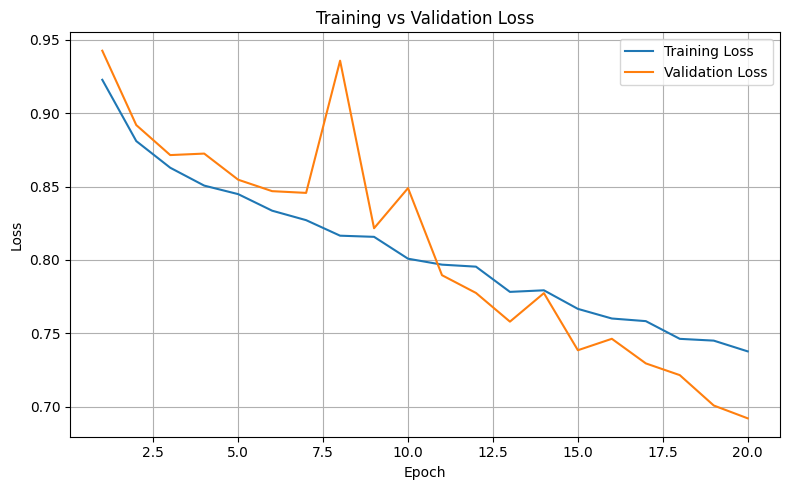

In [39]:
# Choose CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()
# criterion = ordinal_cross_entropy_loss

# optimizer = optim.RMSprop(
#     list(model_full.parameters()) + 
#     list(model_face.parameters()) + 
#     list(mlp_classifier.parameters()),
#     lr=1e-3
# )
optimizer = optim.Adam(
    list(model_full.parameters()) + list(model_face.parameters()) + list(mlp_classifier.parameters()),
    lr=1e-3
)

# Set number of epochs and train the model
num_epochs = 20
train_losses, val_losses, epoch_times = train_combined_model(model_full, model_face, mlp_classifier, train_loader, val_loader, num_epochs, criterion, optimizer, device)

In [31]:

def evaluate_model(model, test_loader, criterion, device, class_names=None):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (x_full, x_face), y_test in test_loader:
            x_full = x_full.to(device)
            x_face = x_face.to(device)
            y_test = y_test.to(device)
            
            logits_test = model(x_full, x_face)
            loss = criterion(logits_test, y_test)
            
            total_loss += loss.item() * x_full.size(0)
            preds = torch.argmax(logits_test, dim=1)
            total_correct += (preds == y_test).sum().item()
            total_samples += x_full.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix (normalized)
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    # values_format='.2f' shows each cell as a decimal with 2 places
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format='.2f')
    plt.title("Normalized Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [28]:
class CombinedModel(nn.Module):
    def __init__(self, model_full, model_face, mlp_classifier):
        super(CombinedModel, self).__init__()
        self.model_full = model_full
        self.model_face = model_face
        self.mlp_classifier = mlp_classifier

    def forward(self, x_full, x_face):
        full_out = self.model_full(x_full)
        face_out = self.model_face(x_face)
        combined = torch.cat((full_out, face_out), dim=1)  # concatenate on feature dimension
        logits = self.mlp_classifier(combined)
        return logits

Test Loss: 0.5289, Test Accuracy: 0.7343


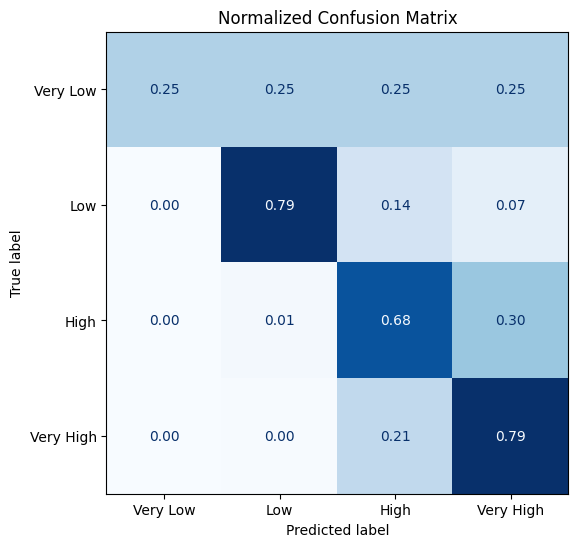


Classification Report:
              precision    recall  f1-score   support

    Very Low       1.00      0.25      0.40         4
         Low       0.80      0.79      0.80        84
        High       0.77      0.68      0.72       882
   Very High       0.70      0.79      0.74       814

    accuracy                           0.73      1784
   macro avg       0.82      0.63      0.66      1784
weighted avg       0.74      0.73      0.73      1784



In [32]:
combined_model = CombinedModel(model_full, model_face, mlp_classifier).to(device)

# Load the separately saved state dicts
checkpoint = torch.load("models/best_combined_model_lstm.pt",weights_only=True)

# Load them into the corresponding parts
combined_model.model_full.load_state_dict(checkpoint['model_full_state_dict'])
combined_model.model_face.load_state_dict(checkpoint['model_face_state_dict'])
combined_model.mlp_classifier.load_state_dict(checkpoint['mlp_classifier_state_dict'])

combined_model.to(device)
combined_model.eval()

class_names = ["Very Low", "Low", "High", "Very High"]
evaluate_model(combined_model, test_loader, criterion, device, class_names)